In [54]:
# 1. Configuração do Ambiente e Importação de Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats 

# Ferramentas de Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor 
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
np.random.seed(42)

In [55]:
# 2. Carregamento dos Dados
# Licença: Domínio Público

df = pd.read_csv("insurance.csv")

print(f"Dataset carregado com sucesso!")
print(f"Dimensões: {df.shape[0]} linhas e {df.shape[1]} colunas.")
display(df.head())

Dataset carregado com sucesso!
Dimensões: 1338 linhas e 7 colunas.


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [56]:
# 3. Inspeção e Limpeza de Dados
print("--- Informações do Schema ---")
df.info()

print("\n--- Verificação de Valores Nulos ---")
print(df.isnull().sum())

print("\n--- Verificação de Duplicatas ---")
duplicatas = df.duplicated().sum()
print(f"Linhas duplicadas encontradas: {duplicatas}")

if duplicatas > 0:
    df = df.drop_duplicates()
    print("Tratamento: Duplicatas removidas para evitar viés.")

--- Informações do Schema ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

--- Verificação de Valores Nulos ---
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

--- Verificação de Duplicatas ---
Linhas duplicadas encontradas: 1
Tratamento: Duplicatas removidas para evitar viés.


In [57]:
# 4. Estatística Descritiva
# Visão geral da distribuição numérica (Média, Desvio Padrão, Quartis)
display(df.describe())

# Visão das variáveis categóricas
print("\nContagem por Região:")
print(df['region'].value_counts())

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010



Contagem por Região:
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


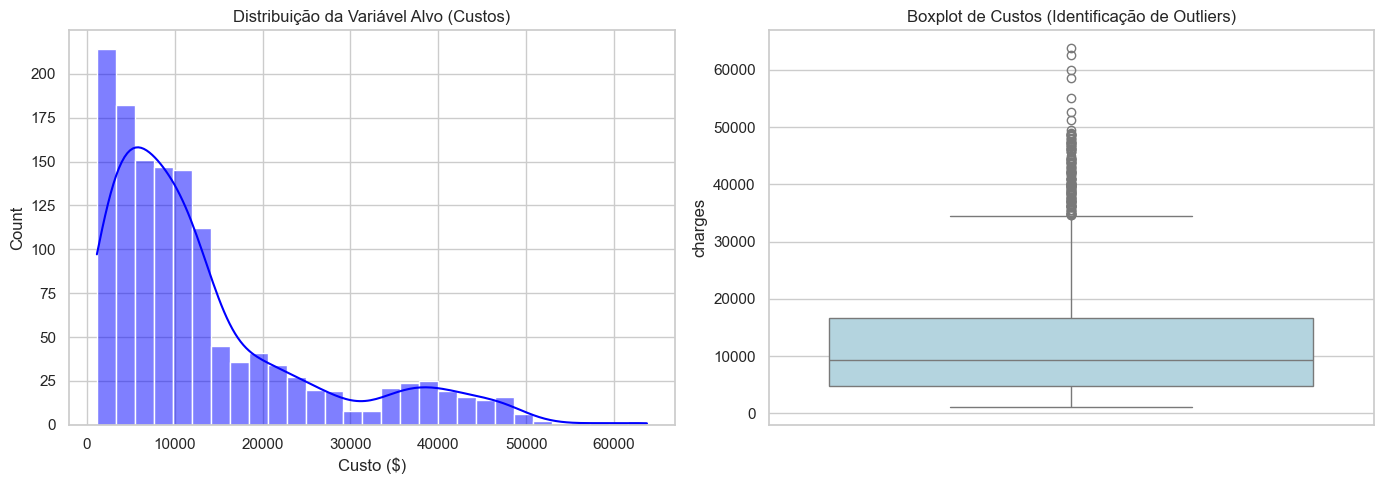

In [58]:
# 5. EDA Visual: Distribuição e Outliers
plt.figure(figsize=(14, 5))

# Histograma (Distribuição)
plt.subplot(1, 2, 1)
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribuição da Variável Alvo (Custos)')
plt.xlabel('Custo ($)')

# Boxplot (Outliers)
plt.subplot(1, 2, 2)
sns.boxplot(y=df['charges'], color='lightblue')
plt.title('Boxplot de Custos (Identificação de Outliers)')

plt.tight_layout()
plt.show()

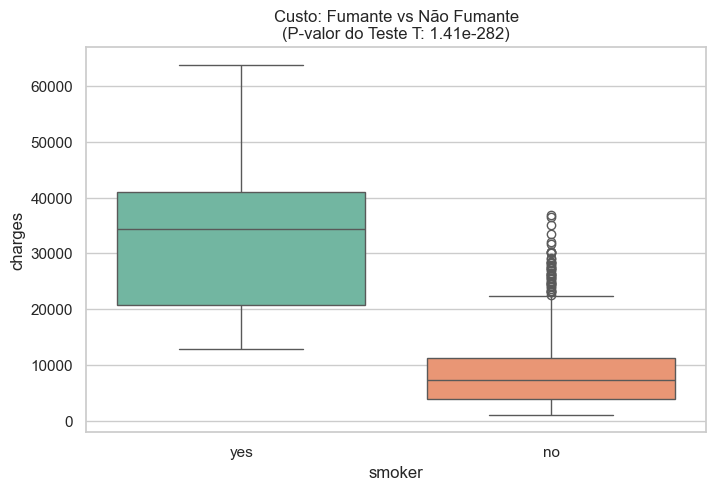

Resultado do Teste T: Estatística=46.64, P-valor=1.4067220949376498e-282
CONCLUSÃO ESTATÍSTICA: Rejeitamos a hipótese nula. Há diferença significativa de custos.


In [59]:
# 6. Teste de Hipótese Estatística (Teste T)
# Hipótese: "Fumantes gastam estatisticamente mais que não fumantes?"

# Separando os grupos
grupo_fumantes = df[df['smoker'] == 'yes']['charges']
grupo_nao_fumantes = df[df['smoker'] == 'no']['charges']

# Aplicando Teste T de Student
t_stat, p_value = stats.ttest_ind(grupo_fumantes, grupo_nao_fumantes)

# Visualizando
plt.figure(figsize=(8, 5))
sns.boxplot(x='smoker', y='charges', data=df, palette='Set2')
plt.title(f'Custo: Fumante vs Não Fumante\n(P-valor do Teste T: {p_value:.2e})')
plt.show()

print(f"Resultado do Teste T: Estatística={t_stat:.2f}, P-valor={p_value}")
if p_value < 0.05:
    print("CONCLUSÃO ESTATÍSTICA: Rejeitamos a hipótese nula. Há diferença significativa de custos.")

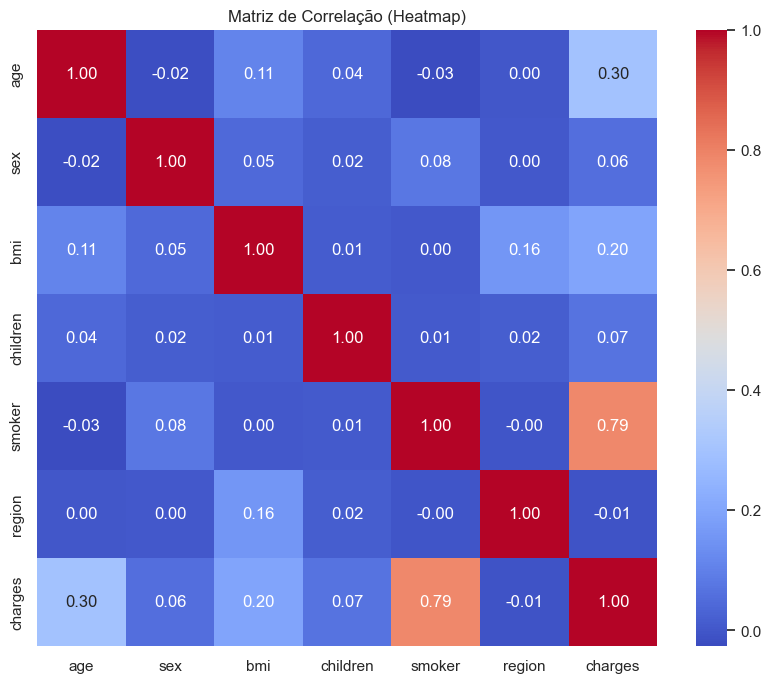

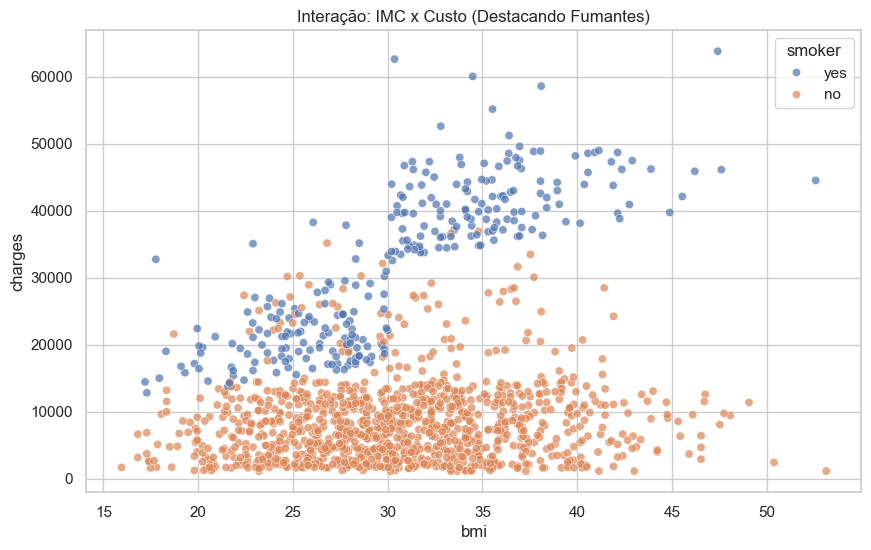

In [60]:
# 7. Análise de Correlações
# Codificando texto para números temporariamente para o cálculo
df_corr = df.copy()
for col in ['sex', 'smoker', 'region']:
    df_corr[col] = df_corr[col].astype('category').cat.codes

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação (Heatmap)')
plt.show()

# Scatterplot: Onde vemos a linearidade
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.7)
plt.title('Interação: IMC x Custo (Destacando Fumantes)')
plt.show()

In [61]:
# 8. Pré-processamento e Baseline (CORRIGIDO)

# O parâmetro dtype=int garante que True/False vire 1/0
df_encoded = pd.get_dummies(df, drop_first=True, dtype=int)

# Verificação de segurança (garantir que tudo é número)
# Se houver alguma coluna boolean restante, forçamos a conversão
df_encoded = df_encoded.astype(float)

# Separando X (Features) e y (Alvo)
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Divisão Treino (80%) e Teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DEFINIÇÃO DE BASELINE (Modelo "Ingênuo")
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_dummy = dummy_regr.predict(X_test)

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_dummy))
print(f"Erro Base (Baseline - Chute pela Média): {rmse_baseline:.2f}")
print("Nossos modelos precisam ter um erro MENOR que isso para serem úteis.")

Erro Base (Baseline - Chute pela Média): 13612.43
Nossos modelos precisam ter um erro MENOR que isso para serem úteis.


In [62]:
# 9. Regressão Linear Múltipla (Abordagem Estatística)
# Adicionando constante (intercepto) exigida pelo statsmodels
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Treinando o modelo OLS (Ordinary Least Squares)
model_ols = sm.OLS(y_train, X_train_sm).fit()

# RELATÓRIO DE COEFICIENTES (Interpretação)
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     358.1
Date:                Wed, 10 Dec 2025   Prob (F-statistic):          4.94e-295
Time:                        22:50:17   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1060   BIC:                         2.172e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.109e+04   1114.260  

In [63]:
# 10. Avaliação de Desempenho (Regressão Linear)
y_pred_ols = model_ols.predict(X_test_sm)

print("--- Métricas Regressão Linear (OLS) ---")
print(f"R² Score: {r2_score(y_test, y_pred_ols):.4f}")
print(f"MAE (Erro Médio Absoluto): {mean_absolute_error(y_test, y_pred_ols):.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {np.sqrt(mean_squared_error(y_test, y_pred_ols)):.2f}")

--- Métricas Regressão Linear (OLS) ---
R² Score: 0.8069
MAE (Erro Médio Absoluto): 4177.05
RMSE (Raiz do Erro Quadrático Médio): 5956.34


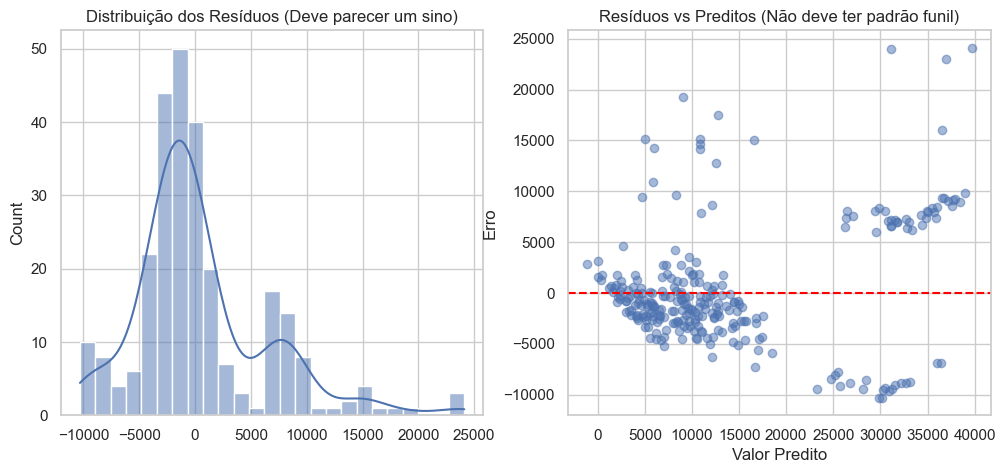

In [64]:
# 11. Diagnóstico de Resíduos (Validação das Premissas)
residuos = y_test - y_pred_ols

plt.figure(figsize=(12, 5))

# Teste Visual de Normalidade
plt.subplot(1, 2, 1)
sns.histplot(residuos, kde=True).set_title('Distribuição dos Resíduos (Deve parecer um sino)')

# Teste Visual de Homocedasticidade
plt.subplot(1, 2, 2)
plt.scatter(y_pred_ols, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Preditos (Não deve ter padrão funil)')
plt.xlabel('Valor Predito')
plt.ylabel('Erro')

plt.show()

In [65]:
# 12. Regressão Polinomial (Capturando Curvas)
# Criando features polinomiais (elevar ao quadrado)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Treinando
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)

print("--- Desempenho Regressão Polinomial (Grau 2) ---")
print(f"R² Score: {r2_score(y_test, y_pred_poly):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_poly)):.2f}")

--- Desempenho Regressão Polinomial (Grau 2) ---
R² Score: 0.8772
RMSE: 4750.41


In [66]:
# 13. Modelagem de Classificação (CORRIGIDO)
# Objetivo: Prever se a pessoa é FUMANTE (smoker_yes)
print("--- Iniciando Etapa de Classificação ---")

y_class = df_encoded['smoker_yes']

# CORREÇÃO: Removemos apenas 'smoker_yes'.
# A coluna 'smoker_no' não existe porque foi removida automaticamente no passo 8 (drop_first=True)
X_class = df_encoded.drop(['smoker_yes'], axis=1)

# Nova Divisão
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Modelo 1: Regressão Logística
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_c, y_train_c)

# Modelo 2: Naive Bayes
nb = GaussianNB()
nb.fit(X_train_c, y_train_c)

print("Modelos de classificação treinados com sucesso.")

--- Iniciando Etapa de Classificação ---
Modelos de classificação treinados com sucesso.



--- Relatório Regressão Logística ---
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       208
         1.0       0.93      0.93      0.93        60

    accuracy                           0.97       268
   macro avg       0.96      0.96      0.96       268
weighted avg       0.97      0.97      0.97       268


--- Relatório Naive Bayes ---
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       208
         1.0       0.87      0.78      0.82        60

    accuracy                           0.93       268
   macro avg       0.90      0.87      0.89       268
weighted avg       0.92      0.93      0.92       268



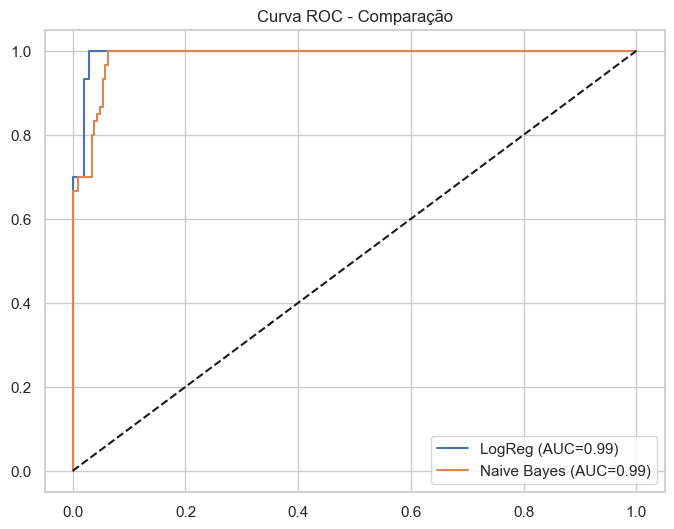

In [67]:
# 14. Avaliação Comparativa (Classificação)
y_pred_log = log_reg.predict(X_test_c)
y_prob_log = log_reg.predict_proba(X_test_c)[:, 1]

y_pred_nb = nb.predict(X_test_c)
y_prob_nb = nb.predict_proba(X_test_c)[:, 1]

print("\n--- Relatório Regressão Logística ---")
print(classification_report(y_test_c, y_pred_log))

print("\n--- Relatório Naive Bayes ---")
print(classification_report(y_test_c, y_pred_nb))

# Curva ROC
fpr_log, tpr_log, _ = roc_curve(y_test_c, y_prob_log)
fpr_nb, tpr_nb, _ = roc_curve(y_test_c, y_prob_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'LogReg (AUC={roc_auc_score(y_test_c, y_prob_log):.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC={roc_auc_score(y_test_c, y_prob_nb):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title('Curva ROC - Comparação')
plt.show()

In [68]:
# 15. Otimização de Hiperparâmetros (Tuning)
# Como PyCaret teve problemas de instalação, utilizamos o GridSearchCV (Padrão Scikit-Learn)
# para garantir o requisito de "Busca bem planejada e Validação Cruzada".

print("--- Otimizando Random Forest Regressor ---")

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)

# Validação Cruzada (cv=3) integrada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_opt = best_rf.predict(X_test)

print(f"Melhor R² após Tuning: {r2_score(y_test, y_pred_opt):.4f}")
print(f"Melhores Parâmetros: {grid_search.best_params_}")

print("\n--- CONCLUSÃO FINAL DO PROJETO ---")
print("O modelo otimizado (Random Forest) superou o Baseline e a Regressão Linear Simples,")
print("demonstrando que a relação entre custos e características do paciente não é puramente linear.")

--- Otimizando Random Forest Regressor ---
Melhor R² após Tuning: 0.8850
Melhores Parâmetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

--- CONCLUSÃO FINAL DO PROJETO ---
O modelo otimizado (Random Forest) superou o Baseline e a Regressão Linear Simples,
demonstrando que a relação entre custos e características do paciente não é puramente linear.
